# BATADAL - ARMA Task

The BATtle of the Attack Detection ALgorithms (BATADAL) data is the hourly historical supervisory control and data acquisition (SCADA) operations of the C-Town water distribution system ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969)).

The purpose of this *ARMA (autoregressive moving average model)* task is to learn an ARMA model for at least 5 individual sensors (pick them in a sensible way!). Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using *Akaike's Information Criterion (AIC)* or another model selection method. Note that there exists a wide range of ARMA variants; we only have to use the basic model. Decide how to set the detection threshold sensibly, study some of the detected anomalies, and answer the following questions:

- What kind of anomalies can you detect using ARMA models? 
- Which sensors can be modeled effectively using ARMA?

## 0. Description of the datasets

Three BATADAL datasets ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/(ASCE)WR.1943-5452.0000969)) are available:

1. *Training dataset 1:* A one-year long simulation data, does not contain any attacks, i.e., all te data pertains to C-Town normal operations.
2. *Training dataset 2:* Partially labelled data of around 6 months long and contains several attacks, some of which are approximately labelled.
3. *Test dataset:* A 3-months long dataset which contains several attacks but no labels. Supposed to be used to compare the performance of the algorithms.

*In this ARMA task we use only the all three datasets to demonstrate our work.*

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, ARMA
from statsmodels.tools.eval_measures import rmse

## 1. Demonstrate the task with variable L_T3
From the familiarization task we knew that tank T3-related parameters have a relatively clear cyclic behaviour. We first would like to demonstrate the ARMA model with an “easy-to-model” variable. The water level of tank T3, L_T3, was chosen for this demonstration. *In this demontration, we use only the first training dataset.*

### 1.1 Autocorrelation plots
We therefore first make autocorrelation plots for the variable L_T3 to get familiar with the ARMA process.

In [2]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

# Set timestamp as index
dftrain1.set_index('DATETIME', inplace = True)

Text(0.5, 0, 'Time (hr)')

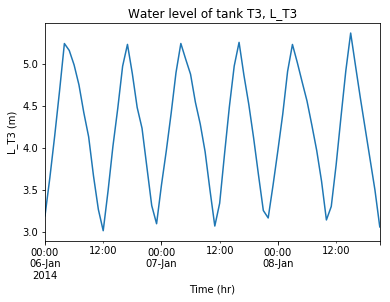

In [3]:
# split data into train and test datasets
def split_train_test(df, n = 24): # n = test size
    train = df[:-n]
    test = df[-n:]
    return train, test

# split the variable in interest (L_T3, tank T3)
train, test = split_train_test(dftrain1.L_T3, n = 24*3)

# plot (a subset of) the training data
train[0:70].plot()
plt.title('Water level of tank T3, L_T3')
plt.ylabel('L_T3 (m)')
plt.xlabel('Time (hr)')

We'd like to find an estimate of appropriate values of p and q in the ARMA(p,q) model. This is done by plotting ([P. Bloomfield, 2011](https://www.stat.ncsu.edu/people/bloomfield/courses/st730/slides/SnS-03-3.pdf)): 
- Partial autocorrelation functions (PACF) for an estimate of *p*, where AR(*p*) is characterized by
  - non-zero at lag *p* and 
  - zeros for lags larger than *p*
- Autocorrelation functions (ACF) for an estimate of q, where MA(*q*) is characterized by
  - non-zero at lag *q* and
  - zeros for lags larger than *q*

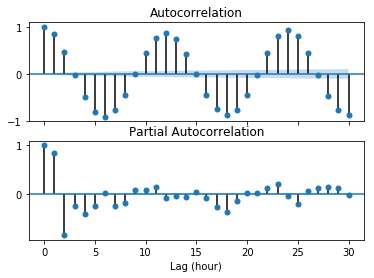

In [4]:
# plot autocorrelation plot and partial autocorrelation plot
def acf_plots(df, lag = 30):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (6, 4))
    
    fig = plot_acf(df, lags = lag, ax = ax1)
    fig = plot_pacf(df, lags = lag, ax = ax2)
    
    ax2.set_xlabel('Lag (hour)')

# plot for training data
acf_plots(train, lag = 30)

From the above PCF plot, we can see that the first spike is located at somewhere lag *p* = 6 or 9. 

Yet it is still difficult to identify the order of lag *q* from above ACF plot. We then make a grid search for finding the order (p, q).

### 1.2 Akaike Information Critera (AIC)
We can check the order by calculating the Akaike Information Critera (AIC) values for the ARMA models. The AIC is a statistical measure which basically quantifies the 1) the goodness of fit and 2) the simplicity/parsimony of the model into a single statistic ([CoolStatsBlog, 2013](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)). The one with the lower AIC is generally “better”, but we're also interested in the “convergence” of the AIC values, i.e., the “good enough” result with the least computation resources.

In [5]:
# perform aic calculations given orders (p, q) and plot the aic grid
def aic_heatmap(df, ps = range(1, 3), qs = range(1, 3), title = 'AIC Grid'):
    aic = [[p, q, ARMA(df, order=(p, q), freq='H').fit().aic]
           for p in ps for q in qs if ((p!=0)|(q!=0))]
    aic = pd.DataFrame(aic, columns = ['p', 'q', 'aic'])
    
    # plot heatmap showing aic values vs (p, q) parameters
    sns.heatmap(aic.pivot('p', 'q', 'aic'), 
                annot = True, fmt='0.1f', linewidths=1)
    plt.title(title)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


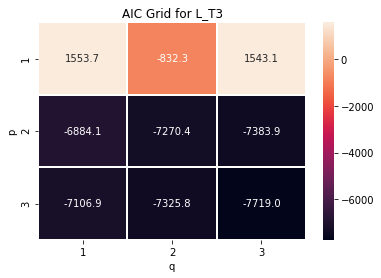

In [6]:
aic_heatmap(train, ps = range(1, 3+1), qs = range(1, 3+1), 
            title = 'AIC Grid for L_T3')

### 1.3 Predicting the next value
We can see from the AIC grid graph that higher orders of p and q return a lower AIC score, and that in this grid search, the parameter set of (p, q) = (2, 1) gives a sufficiently good result. After the order of (2, 1), an increase in either p or q gives relatively small improvement in the AIC score. We therefore proceed with an ARMA model with an order of (2, 1).

In [9]:
# train model to predict the next value per time tick
def arma_train_predict(train, test, p, q, showlog = False):
    history = [x for x in train] # set history (=training data)
    model = ARMA(history, order = (p, q)).fit() # first fit of model with train data
    residual = [x for x in model.resid] # get residuals from train data
    predictions = [] # start prediction
    
    # train model and predict the next time tick
    for t in range(len(test)):
        model = ARMA(history, order = (p, q)).fit()
        vPred = model.forecast(steps = 1)[0]
        vReal = test.values[t]
        predictions.append(float(vPred))
        history.append(vReal)
        residual.append(vReal - vPred)
        if showlog:
            print('i = %i\treal:%0.2f\tpredict: %0.2f\tresidual: %0.2f' % (t, vReal, vPred, vReal-vPred))
    
    # calculate few output statistics
    error = rmse(test.values, np.array(predictions)) # root mean square error
    max_residual = np.abs(residual).max() # max residual
    
    return predictions, error, max_residual

In [11]:
# perform arma modeling and predicting
predictions, error, max_residual = arma_train_predict(train, test, p=2, q=2) #if necessary set showlog = True

print('ARMA resulting root mean square error: %0.3f' % error)
print('ARMA resulting max residual: %0.3f' % max_residual)

ARMA resulting root mean square error: 0.150
ARMA resulting max residual: 1.011


In [12]:
# plot the real vs prediction data
def real_vs_predict(test, predictions, title = 'Variable in interest',
                    ylabel = 'Unit', xlabel = 'Time (hr)'):
    comparison = pd.DataFrame({'original' : test,
                               'predict' : predictions})
    comparison.plot(style = ['b--','r--'])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

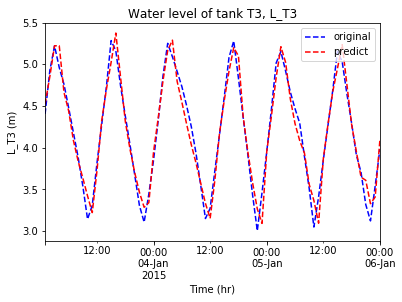

In [13]:
real_vs_predict(test, predictions, 
                title = 'Water level of tank T3, L_T3', 
                ylabel = 'L_T3 (m)')

## 2. Other signals

Four other individual signals are selected for the ARMA task. The results are shown in another notebook file: *Task2_ARMA-other signals*.ipynb. Below is the list of the selected signals:
- Water level of tank T1, *L_T1*
- Water level of tank T2, *L_T2*
- Pressure at junction J302, *P_J302*
- Flowrate at pump PU2, *F_PU2*

From the results we can see that ARMA method **performs better for "continuous" signals such as the water level of tanks**. The method returns larger errors when dealing with more "discretized" signals such as the flowrate of pumps (which is zero when pumps are not activated) and the pressure readings of the junctions.

## 3. Detecting anomalies
We now apply ARMA model for anomalies dection by the following steps:
- Train the model using *training dataset 1*;
- Test the model using *training dataset 2*.

In [14]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')
dftrain2 = pd.read_csv('./data/BATADAL_dataset04.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

# Remove the spaces in column names
dftrain2.columns = dftrain2.columns.str.strip()

# Set timestamp as index
dftrain1.set_index('DATETIME', inplace = True)
dftrain2.set_index('DATETIME', inplace = True)

As running the whole *training dataset 2* for predictions is very time consuming, we will run a "subset" of the data for the demontration of task. We will perform the anomaly detection task by using a subset of an attack activity **plus extra time** before and after the given period.

In [111]:
# get subset of an attack activity (if necessary plus extra time) in training dataset 2
def get_attack_activities(signals, period, extratime = 0):
    # get the index of the slice of data at given period
    id_attack = [int(np.where(dftrain2.index == pd.to_datetime(time, format = '%d/%m/%y %H'))[0]) 
                 for time in period]
    # subset the df in interest
    df = dftrain2[[*signals, 'ATT_FLAG']][id_attack[0]-extratime : id_attack[1]+extratime]
    df.loc[df.ATT_FLAG < 0, 'ATT_FLAG'] = 0 #ATT_FLAG: 0=normal, 1=under attack
    # add a column with flag of actual attack period
    df['ATT_FLAG_ad'] = 0
    df.iloc[extratime : len(df)-extratime, -1] = 1 #ATT_FLAG_ad: 0=normal, 1=under attack
    return df

### 3.1 Attack ID #1

We demonstrate the detection task using *Attack ID #1* in training dataset 2. The attack period is 13/09/2016 23 ~ 16/09/2016 00 (duration 50 hrs; labelled 42 hrs).

During this attack activity, the attacker changes L_T7 thresholds, which controls PU10/PU11, and therefore results in low level in L_T7. We first use an extra 100 hrs before and after the activity.

In [213]:
# subset and show the attack profile
signals = ['L_T7', 'P_J317', 'F_PU10', 'F_PU11'] # tank T7-correlated variables
period = ['13/09/16 23', '16/09/16 00'] # period of attack ID #1
extratime = 100

test_df = get_attack_activities(signals, period = period, extratime = extratime)

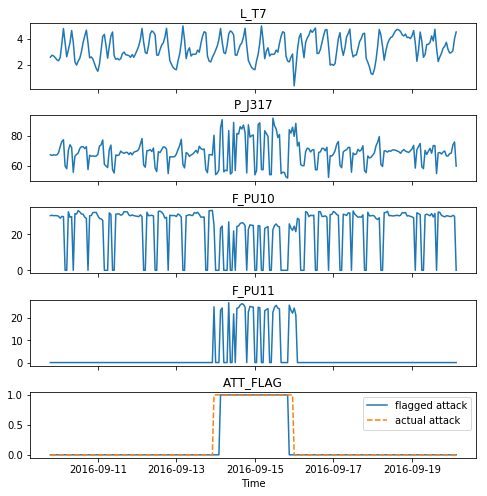

In [214]:
# make subplot of variables
def plot_attack_profile(test_df):
    fig, ax = plt.subplots(len(test_df.columns.to_list())-1, 1, figsize = (8, 8), sharex = True)
    fig.subplots_adjust(hspace = 0.4)

    for var in test_df.columns.to_list():
        i = test_df.columns.to_list().index(var)
        ax[i, ].plot(test_df[var])
        ax[i, ].set_title(var)
        if var == 'ATT_FLAG': # plot ATT_FLAG_ad together with ATT_FLAG
            ax[i, ].plot(test_df['ATT_FLAG_ad'], '--')
            ax[i, ].legend(['flagged attack', 'actual attack'])
            break
    ax[i, ].set_xlabel('Time')

plot_attack_profile(test_df)

From the attack profile, we can see that L_T7 presents a **point anomaly** (which is the low level as the result of the attack) in the end of the attack period.

In [215]:
# define train and test data (for a single signal)
signal = 'L_T7'

test = test_df[signal]
train = dftrain1[signal]

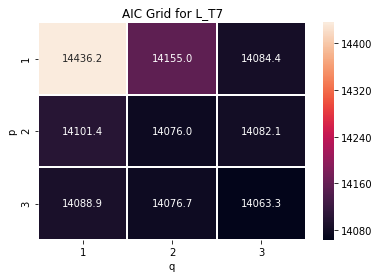

In [179]:
# double-check that the ARMA(p, q) model is sufficiently good
aic_heatmap(train, ps = range(1, 3+1), qs = range(1, 3+1), 
            title = 'AIC Grid for L_T7')

In [216]:
# predict training-2 series based on training-1 data
predictions, error, max_residual = arma_train_predict(train, test, p=2, q=2) #if necessary set showlog = True

print('ARMA resulting mean square error: %0.3f' % error)
print('ARMA resulting max residual: %0.3f' % max_residual)

ARMA resulting mean square error: 0.579
ARMA resulting max residual: 2.683


In [217]:
# compute residuals
res = np.subtract(test, predictions)
res = abs(res - np.mean(res))

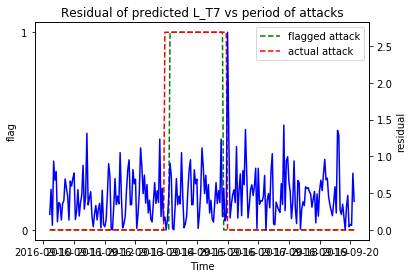

In [218]:
# plot the reiduals vs Attack flags
def plot_residual_vs_attack(residual, test_df, signal = 'signal', showfrom = 10): 
    fig, ax1 = plt.subplots(figsize=(10, 5))
    # showfrom n: trust the predicting results from (n+1)th on, default n=10
    ax1.plot(test_df['ATT_FLAG'][showfrom:], 'g--')
    ax1.plot(test_df['ATT_FLAG_ad'][showfrom:], 'r--')
    ax1.legend(['flagged attack', 'actual attack'])
    ax1.set_ylabel('flag')
    ax1.set_yticks([0, 1])
    ax1.set_xlabel('Time')
    
    ax2 = ax1.twinx()
    ax2.plot(residual[showfrom:], 'b')
    ax2.set_ylabel('residual')
    ax2.set_title('Residual of predicted %s vs period of attacks' % signal)
    fig.autofmt_xdate()

plot_residual_vs_attack(res, test_df, signal)

The point anomaly can be detected with a threshold of ~1.5 *(or the max residual for normal data)*. However, this point anomaly took place in the very end of the attack period. Therefore, the attack detection would be inefficient if the detection process is relying on L_T7. 

### 3.2 Attack ID #3

We further demonstrate the detection task using *Attack ID #3* in training dataset 2. The attack period is 09/10/2016 09 ~ 11/10/2016 20 (duration 60 hrs; labelled 60 hrs).

During this attack activity, the attacker alters L_T1 reading, which reads a constant low level and keeps PU1/PU2 ON, and therefore results in overflow in L_T1. We use an extra 100 hrs before and after the activity.

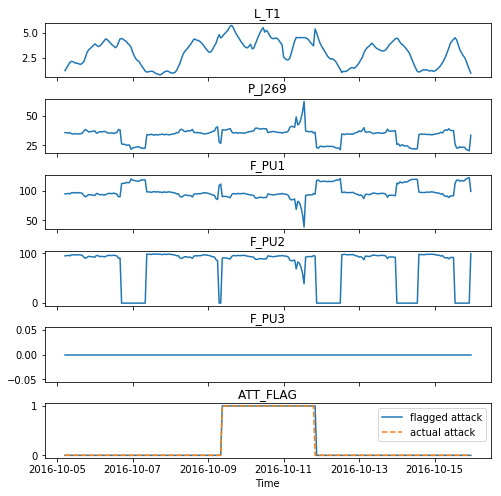

In [206]:
# subset and show the attack profile
signals = ['L_T1', 'P_J269', 'F_PU1', 'F_PU2', 'F_PU3'] # Tank T1-correlated variables
period = ['09/10/16 09', '11/10/16 20'] # period of attack ID #3
extratime = 100

test_df = get_attack_activities(signals, period = period, extratime = extratime)

# show the attack profile
plot_attack_profile(test_df)

From the attack profile, we can see that L_T1 presents a **collective anomaly** (which is the overflow as the result of the attack) throughout the attack period.

In [196]:
# define train and test data (for a single signal)
signal = 'L_T1'

test = test_df[signal]
train = dftrain1[signal]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


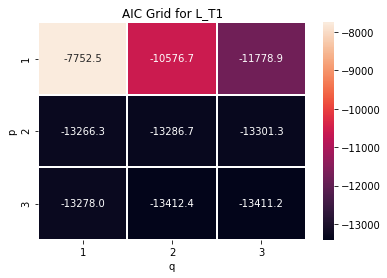

In [197]:
# double-check that the ARMA(p, q) model is sufficiently good
aic_heatmap(train, ps = range(1, 3+1), qs = range(1, 3+1), 
            title = 'AIC Grid for L_T1')

In [198]:
# predict training-2 series based on training-1 data
predictions, error, max_residual = arma_train_predict(train, test, p=2, q=1) #if necessary set showlog = True

print('ARMA resulting mean square error: %0.3f' % error)
print('ARMA resulting max residual: %0.3f' % max_residual)

ARMA resulting mean square error: 0.280
ARMA resulting max residual: 2.166


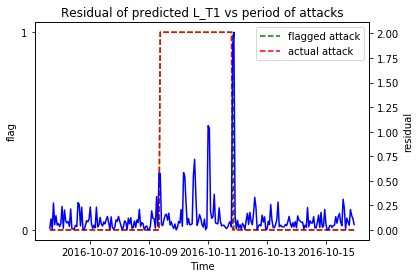

In [212]:
# compute residuals and plot versus attack profile
res = np.subtract(test, predictions)
res = abs(res - np.mean(res))

plot_residual_vs_attack(res, test_df, signal)

The point anomaly can be detected with a threshold of ~0.4 *(or the max residual for normal data)*. ARMA model has a very nice performance on detecting collective anomalies.

### 3.2 Conclusion

For anomaly detection, the threshold can be set as the max residual for normal data (with a multiplier of some 1.1 or 1.5, if necessary). ARMA model performs well when dealing with "continuous" data; in this case, the water level of tanks.